#6 Transformer based Text Classfication

In this session we'll make use of pre-trained Transformer models for building various types of text classifiers, some of which are multi-lingual. In particular, the notebook demonstrates the training of BERT-based text classifiers for: 
- categorising news group messages 
- detecting sentiment in Twitter messages
- determining if a sentence paraphrases another.

The notebook makes use of: 
- the ktrain wrapper: https://github.com/amaiya/ktrain
- for training Transformer models from HuggingFace: https://github.com/huggingface/transformers

Much of the notebook is based on: 
- this blog post: https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed
- this Google Colab notebook: https://colab.research.google.com/drive/1YxcceZxsNlvK35pRURgbwvkgejXwFxUt
- this notebook: https://github.com/amaiya/ktrain/blob/master/examples/text/MRPC-BERT.ipynb


## 6.1  Check GPU and install ktrain library

**NOTE**: To run this notebook, you will **need a GPU** (Graphics Processing Unit) card 
- the notebook has been tested on Google Colab and you are advised to run it there
- to use a GPU, you need to click on "Runtime" above, then "Change runtime type" and for "Hardware accelerator" choose the "GPU" option

Run the code below to check whether there is a gpu available:

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 6.2  Load the 20 Newsgroups dataset

In the first example we'll build a multi-class classifier for newsgroup messages, as examples of longer text messages.

Training on all of the documents in the dataset will take too long (a few hours), so we'll use just 4 today. 
- If you want to try on the full dataset, just remove the 'categories' attribute from the commands below. 
- Be warned though, that training time will be MUCH longer if you include all of the data, so first try subset of the categories.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.graphics', 'rec.sport.baseball', 'sci.med', 'alt.atheism']
train = fetch_20newsgroups(subset='train', shuffle=True, categories=categories)
test = fetch_20newsgroups(subset='test', shuffle=True, categories=categories)

Print out some basic information about the dataset:

In [ ]:
print('# train instances: ', len(train.data))
print('# test instances:  ', len(test.data))
print('classes: ', train.target_names)

# train instances:  2255
# test instances:   1501
classes:  ['alt.atheism', 'comp.graphics', 'rec.sport.baseball', 'sci.med']


A class histogram shows that there is a relatively even distribution of messages across the categories:

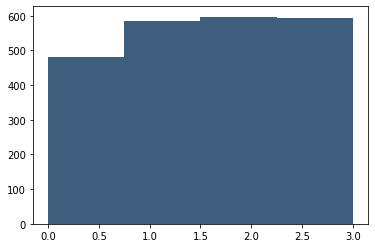

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train.target,bins=len(train.target_names),color="#3F5D7D");

## 6.3 Creating a model and preprocessing data

We'll use the 'ktrain' library to manage the learning process, so install it: 

In [ ]:
!pip install -q ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 78.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 KB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 114.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 47.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

and then import the text module from ktrain:

In [ ]:
import ktrain
from ktrain import text

For the moment we will use the standard pretrained Multilingual BERT model. Note that this **model is big**! 
- it contains 110 million parameters
- it represents words (subword tokens to be precise) with embeddings of size 768 <-- compare this with the 50 dimensions we used with GloVe
- it contains 12 self-attention layers (each with 12 heads) stacked on top each other

In [ ]:
model_name = 'bert-base-multilingual-uncased'

There are many other pretrained models availalable here: https://huggingface.co/transformers/pretrained_models.html
- Give them a try and see which ones are faster and/or more stable to train!

Load the transformer setting the maximum text length to 500 and the classes to be the four newsgroup categories mentioned above.

In [ ]:
transformer = text.Transformer(model_name, maxlen=500, class_names=train.target_names)

Now that we've downloaded the base Multiligual BERT model, let's have a look at the architecture and how many parameters it contains. 

In [ ]:
print(transformer.get_model().summary(show_trainable=True))


/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:393: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(


Model: "tf_bert_for_sequence_classification_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 bert (TFBertMainLayer)      multiple                  16735641  Y          
                                                       6                    
                                                                            
 dropout_75 (Dropout)        multiple                  0         Y          
                                                                            
 classifier (Dense)          multiple                  3076      Y          
                                                                            
Total params: 167,359,492
Trainable params: 167,359,492
Non-trainable params: 0
____________________________________________________________________________
None


Now we can preprocess the training (and test) data using the transformer's tokenizer:

In [ ]:
processed_train = transformer.preprocess_train(train.data, train.target)
processed_test = transformer.preprocess_test(test.data, test.target)

preprocessing train...
language: en
train sequence lengths:
	mean : 269
	95percentile : 722
	99percentile : 1769


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 299
	95percentile : 784
	99percentile : 2150


Let's have a quick look at what the tokenised data looks like: 
- First print out the text of the first document:

In [ ]:
print(train.data[0])

From: cab@col.hp.com (Chris Best)
Subject: Re: Is MSG sensitivity superstition?
Organization: your service
Lines: 20
NNTP-Posting-Host: hpctdkz.col.hp.com


Jason Chen writes:
> Now here is a new one: vomiting. My guess is that MSG becomes the number one
> suspect of any problem. In this case. it might be just food poisoning. But
> if you heard things about MSG, you may think it must be it.

----------

Yeah, it might, if you only read the part you quoted.  You somehow left 
out the part about "we all ate the same thing."  Changes things a bit, eh?

You complain that people blame MSG automatically, since it's an unknown and
therefore must be the cause.  It is equally (if not more) unreasonable to
defend it, automatically assuming that it CAN'T be the culprit.

Pepper makes me sneeze.  If it doesn't affect you the same way, fine.
Just don't tell me I'm wrong for saying so.

These people aren't condemning Chinese food, Mr. Chen - just one of its 
(optional) ingredients.  Try not to take 

Now print out the result of preprocessing the first document: 

In [ ]:
print(processed_train.x[0][0])

[  101 10195   131 70438   137 12308   119 20931   119 10241   113 13446
 11146   114 19513   131 11449   131 10127 16777 10251 20242 14119 52902
 12278 12054 11101   136 14935   131 12787 11416 17294   131 10200 37580
 84723   118 42191 10422   118 17624   131 20931 15106 10163 10167 10311
   119 12308   119 20931   119 10241 17110 20728 47332   131   135 11628
 14048 10127   143 10246 10399   131 11106 69431   119 11153 41567 22523
 10127 10203 16777 10251 23259 10103 11395 10399   135 75695 10108 11318
 15640   119 10104 10372 12700   119 10197 20025 10346 12125 15225 55340
 10285   119 10502   135 11526 10855 27134 17994 10935 16777 10251   117
 10855 10431 21506 10197 14650 10346 10197   119   118   118   118   118
   118   118   118   118   118   118 82600   117 10197 20025   117 11526
 10855 10902 18593 10103 10649 10855 62259   119 10855 10970 38644 12174
 10871 10103 10649 10935   107 11312 10367 12811 10103 11714 21973   119
   107 17992 17994   143 16464   117 58375   136 10

Each integer above is the index of a token from the vocabulary of the BERT model. 
- How big is the vocabulary?

In [ ]:
print("vocabulary size: ", len(transformer.tok.vocab))

vocabulary size:  105879


This vocabulary is relatively small compared to many word embeddings discussed in the lecture, which often reach over 1 million distinct words. 
- The vocab size is kept relatively small through the use of sub-word tokens that are found using a byte-pair encoding scheme.
- We can take a single string and run it through the tokenizer to see the tokens produced as follows:

In [ ]:
example_text = "I always wondered what those Transformer models were doing to my text. Here is an OutOfVocabWord."
encoded_text = transformer.tok.encode(example_text)
vocab_terms = list(transformer.tok.vocab.keys())
vocab_index = list(transformer.tok.vocab.values())
print("input text: "+example_text)
print("tokenized:  ", [vocab_terms[vocab_index.index(i)] for i in encoded_text])

input text: I always wondered what those Transformer models were doing to my text. Here is an OutOfVocabWord.
tokenized:   ['[CLS]', 'i', 'always', 'wonder', '##ed', 'what', 'those', 'transforme', '##r', 'models', 'were', 'doing', 'to', 'my', 'text', '.', 'here', 'is', 'an', 'out', '##of', '##vo', '##ca', '##b', '##word', '.', '[SEP]']


Note that:
- a '[CLS]' token has been added to the start of the tokenized text and a '[SEP]' token to the end.
- BERT works as a masked autoencoder, meaning that it is trained to produce the same terms as output that are presented in input, including those that were masked out.
- the '[CLS]' token is simply a special mask for the unknown class label that needs to be produced at the output. 
- the Byte-Pair Encoding has removed the suffixes from certain words (e.g. 'wondered' lost the 'ed'), but not all of them ('models' kept the 's'). 

## 6.4  Training the model

Now we're ready to start training the model. 
- So get the classification model and create a learner:

In [ ]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=6)

Run the learner to do some simulated runs and try to determine the best setting of the learning rate.

> Indented block



simulating training for different learning rates... this may take a few moments...
375/375 [==============================] - 266s 657ms/step - loss: 13.2169 - accuracy: 0.3499


done.
Visually inspect loss plot and select learning rate associated with falling loss


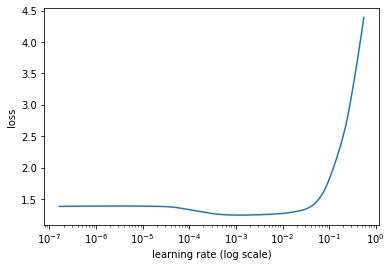

In [ ]:
learner.lr_find(show_plot=True, max_epochs=1)

Based on the plot above, we'll select a learning rate of 0.5*10^-4 
- The recommendation form ktrain is to choose as big a value as possible where the loss is still decreasing (https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c)
- Too high a value for the learningn rate can make training unstable and cause the model to collapse.
- In order to not have to wait too long, we'll run the training for 2 epochs (4 would be better).

In [ ]:
learner.fit_onecycle(0.5e-4, 2)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/2
376/376 [==============================] - 369s 942ms/step - loss: 0.4342 - accuracy: 0.8576 - val_loss: 0.2017 - val_accuracy: 0.9420
Epoch 2/2
376/376 [==============================] - 351s 934ms/step - loss: 0.1070 - accuracy: 0.9721 - val_loss: 0.1962 - val_accuracy: 0.9514


## 6.5  Evaluating the model

Now that the model has finished training, let's evaluate in on the test data.

In [ ]:
learner.validate(class_names=transformer.get_classes())

47/47 [==============================] - 65s 1s/step
                    precision    recall  f1-score   support

       alt.atheism       0.92      0.95      0.94       319
     comp.graphics       0.91      0.97      0.94       389
rec.sport.baseball       1.00      0.92      0.96       397
           sci.med       0.97      0.95      0.96       396

          accuracy                           0.95      1501
         macro avg       0.95      0.95      0.95      1501
      weighted avg       0.95      0.95      0.95      1501



array([[304,   9,   1,   5],
       [  9, 379,   0,   1],
       [ 13,  12, 367,   5],
       [  3,  15,   0, 378]])

We can have a look at the test examples on which the model made the worst predictions:

In [ ]:
learner.view_top_losses(n=1, preproc=transformer)

47/47 [==============================] - 60s 1s/step
----------
id:1288 | loss:6.96 | true:rec.sport.baseball | pred:alt.atheism)



Print out the post with the top loss (by changing INDEX_OF_INSTANCE below) to try to find out why it is confusing the classfier. 

In [ ]:
index_of_instance = 1211
print(test.data[index_of_instance])

From: scordova@epas.utoronto.ca (Stephen Cordova)
Subject: Rusty's religion
Organization: University of Toronto - EPAS
Nntp-Posting-Host: epas.utoronto.ca
Lines: 4

As I recall from Kieth Hernandez' 'auto'biography, Rusty is a devout
Roman Catholic.  Kieth and Rusty would carpool to Shea everyday but
Sunday, when Rusty would go to mass.
SC



## 6.6 Making predictions on new data

We can run the trained classification model on new examples. 
- Get a predictor object and call predict() with the desired text:

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
sample_text = 'Both of the home runs hit by Fernando Tatís in the third inning for the St. Louis Cardinals on April 23, 1999, were grand slams.'
predictor.predict(sample_text)

1/1 [==============================] - 0s 79ms/step


'rec.sport.baseball'

We can see the probabilities assigned by the model to each of the classes as follows:

In [ ]:
predictor.predict_proba(sample_text)

1/1 [==============================] - 0s 71ms/step


array([7.8382628e-04, 3.4322592e-03, 9.9459887e-01, 1.1850800e-03],
      dtype=float32)

Where the classes are:

In [ ]:
predictor.get_classes()

['alt.atheism', 'comp.graphics', 'rec.sport.baseball', 'sci.med']

OK, so the model appears to work well on English text.

## 6.7 Multi-lingual examples

Let's try on a phrase in another language (Italian). 
- Note that the news group data we used to train the model is in English only, so the model has never seen any examples of news group messages in Italian.

In [ ]:
italian_text = 'I tasti su e giù sul mio portatile non funzionano più, quindi non posso più usarlo per giocare ;-('
predictor.predict(italian_text)

1/1 [==============================] - 0s 70ms/step


'comp.graphics'

In [ ]:
predictor.predict_proba(italian_text)

1/1 [==============================] - 0s 68ms/step


array([0.02248108, 0.87233365, 0.0291552 , 0.07603012], dtype=float32)

Did it get the prediction right? 
- Note that while the characer set for Italian and English is almost the same, there weren't any words (except perhaps for "non") in the above message that would have occurred in the training data. 

Let's try a message in a different character set: 
- Translate the text into Chinese using Google Translate: https://translate.google.com/
- Then copy the text below and rerun the prediction. 
- Does it still work? 



In [ ]:
chinese_text = '笔记本电脑上的向上和向下键不再起作用，因此我无法再使用它来播放;-(' #'INSERT CHINESE TEXT HERE'
predictor.predict(chinese_text)

1/1 [==============================] - 0s 76ms/step


'comp.graphics'

In [ ]:
russian_text = "Клавиши «вверх» и «вниз» на моем ноутбуке больше не работают, поэтому я больше не могу использовать их для игры ;-("
predictor.predict(russian_text)

1/1 [==============================] - 0s 72ms/step


'comp.graphics'

## 6.8  Explaining the predictions

Let's try another piece of text, this time in English, but talking about a politician who wasn't a politician (but rather a celebrity) at the time in which the 20 News Groups dataset was created:

In [ ]:
sample_text = 'Donald Trump is the greatest living ex-president in the history of living ex-presidents. He\'s also a bad golfer.'
predictor.predict(sample_text)

1/1 [==============================] - 0s 68ms/step


'alt.atheism'

Let's invoke the `explain` method to see which words contribute most to the classification.

We will need a forked version of the **eli5** library that supportes TensorFlow Keras, so let's install it first.

In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

  Preparing metadata (setup.py) ... done


Run the explainer (based on LIME) to see which words in the sentence are most important for the prediction:

In [ ]:
predictor.explain(sample_text)

79/79 [==============================] - 8s 95ms/step


The words in the darkest shade of green contribute most to the classification.
- Do they agree with what you would have expected for this example?

## 6.9 Inspecting the Model

Let's have a look at the architecture of the model that we have used:

In [ ]:
print(model.summary())

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  167356416 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 167,359,492
Trainable params: 167,359,492
Non-trainable params: 0
_________________________________________________________________
None


The model contains over 100 million parameters consists of:
- BERT (which contains alost all the parameters), 
- a drop-out layer (that is inserted to prevent overfitting), and 
- a dense (feedforward) layer to map the BERT embedding of size 768 to the 4 output neurons (representing the four classes).

Let's print out information on the BERT model.

In [ ]:
print(transformer.get_model().bert.config)

BertConfig {
  "_name_or_path": "bert-base-multilingual-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  

And we can list all the submodules present in BERT

In [ ]:
model.bert.submodules

(<transformers.models.bert.modeling_tf_bert.TFBertEmbeddings at 0x7fbdf4f879a0>,
 <keras.layers.core.dense.Dense at 0x7fbd62c08d60>)

## 6.10 Saving and loading a fine-tuned model

We can save predictor for later use

In [ ]:
predictor.save('/tmp/my_predictor')

Reload the predictor and use it to predict the class of a new piece of text:

In [ ]:
reloaded_predictor = ktrain.load_predictor('/tmp/my_predictor')
reloaded_predictor.predict('My computer monitor is really blurry.')

1/1 [==============================] - 5s 5s/step


'comp.graphics'

## 6.11 Classifying the sentiment of Twitter messages

We'll now train a different model to detect sentiment on Twitter data as we did for the previous tutorials:

In [ ]:
import nltk
nltk.download('twitter_samples')

from nltk.corpus import twitter_samples
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

import re 
emoticon_regex = '(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)'
positive_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in positive_tweets]
negative_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in negative_tweets]

tweets_x = positive_tweets_noemoticons + negative_tweets_noemoticons
tweets_y = ['positive']*len(positive_tweets) + ['negative']*len(negative_tweets)

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


Use scikit-learn to split the data into training, validation and test sets:


In [ ]:
from sklearn.model_selection import train_test_split
temp_x, test_x, temp_y, test_y = train_test_split(tweets_x, tweets_y, test_size=0.2)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.2)

Now **repeat** all the steps from before for the twitter data: 

1.   Load the model (this time we'll try DistilBERT, which is a smaller transformer model)

In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
transformer = text.Transformer(MODEL_NAME, maxlen=500, classes=['positive','negative'])

/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:383: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn(


2. Process the training/test data

In [ ]:
processed_train = transformer.preprocess_train(train_x, train_y)
processed_test = transformer.preprocess_test(valid_x, valid_y)

preprocessing train...
language: en
train sequence lengths:
	mean : 11
	95percentile : 23
	99percentile : 27


/usr/local/lib/python3.8/dist-packages/ktrain/utils.py:745: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 11
	95percentile : 23
	99percentile : 27


3. Create a model and learner

In [ ]:
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=6)

4.   Train the model (We'll run for one epoch to make it faster, but it would be better to run for 4 or more)

In [ ]:
learner.fit_onecycle(0.5e-4, 1)



begin training using onecycle policy with max lr of 5e-05...
1067/1067 [==============================] - 394s 360ms/step - loss: 0.4544 - accuracy: 0.7686 - val_loss: 0.3712 - val_accuracy: 0.8294


5.   Evaluate the model

In [ ]:
learner.validate(class_names=transformer.get_classes())

50/50 [==============================] - 5s 74ms/step
              precision    recall  f1-score   support

    negative       0.81      0.85      0.83       794
    positive       0.85      0.81      0.83       806

    accuracy                           0.83      1600
   macro avg       0.83      0.83      0.83      1600
weighted avg       0.83      0.83      0.83      1600



array([[675, 119],
       [154, 652]])

6.   Make some predictions with it

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
predictor.predict('Had a lot of fun today!')

1/1 [==============================] - 0s 63ms/step


'positive'

Did it work?

Let's print out some information about the architecture of this model:

In [ ]:
print(model.summary())

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_267 (Dropout)       multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________
None


We see that the distilbert model has fewer parameters than the BERT model we used previously. It's interesting to see the pre-classifier layer in this model that maps the output embeddings from the transformer into a second embedding space (of the same size) that is then used as features for the final classification layer.


## 6.12 Pairwise classification task 

We now use the Microsoft Research Paraphrase Corpus (MRPC) to build a classifier for detecting paraphrased sentences. 
- This is an example of a paired sentence classfication task, where the prediction model takes in a **pair of texts as input** and produces a **binary label as output**.

We'll first use pandas (Python's data analysis library) to download and parse the tab-separated data:

In [ ]:
import pandas as pd
import csv
train_file = 'https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt'
test_file = 'https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt'
train_df = pd.read_csv(train_file, delimiter='\t', quoting=csv.QUOTE_NONE)
test_df = pd.read_csv(test_file, delimiter='\t', quoting=csv.QUOTE_NONE)

We need to format the training data in the format needed for ktrain
- so select the two columns containing strings 
- and get their values (as an 2d array) 
- then convert the array to a list of tuples (str,str) as required by ktrain:

In [ ]:
x_train = train_df[['#1 String', '#2 String']].values
# for sentence pair classification, ktrain expects a list of tuples of form (str, str)
x_train = list(map(tuple, x_train))

Repeat for the test data:

In [ ]:
x_test = test_df[['#1 String', '#2 String']].values
x_test = list(map(tuple, x_test))

And of course, we need also the labels for the training / test examples:

In [ ]:
y_train = train_df['Quality'].values
y_test = test_df['Quality'].values

Print out sizes of dataset:


In [ ]:
print("# train instances: ",len(x_train))
print("# test instances:  ",len(x_train))

# train instances:  4076
# test instances:   4076


Have a look at a random sentence pair:

In [ ]:
import random 
i = random.randint(0,len(x_train)-1)
print("Sentance 1: "+x_train[i][0])
print("Sentence 2: "+x_train[i][1])
print("Label:      "+str(y_train[i]))

Sentance 1: And now it 's anything he wants to say , " Alesha Badgley , Stone County Nursing and Rehabilitation Center social director , said this week .
Sentence 2: And now it 's anything he wants to say , " confirmed Stone County Nursing and Rehabilitation Center social director Alesha Badgley .
Label:      1


Build and train a model:

In [ ]:
MODEL_NAME = 'bert-base-uncased'
transformer = text.Transformer(MODEL_NAME, maxlen=128, class_names=['not paraphrase', 'paraphrase'])
processed_train = transformer.preprocess_train(x_train, y_train)
processed_test = transformer.preprocess_test(x_test, y_test)
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=32)
learner.fit_onecycle(5e-5, 3)

preprocessing train...
language: en
sentence pairs detected


Is Multi-Label? False
preprocessing test...
language: en
sentence pairs detected




begin training using onecycle policy with max lr of 5e-05...
Epoch 1/3
128/128 [==============================] - 132s 916ms/step - loss: 0.5989 - accuracy: 0.6744 - val_loss: 0.4720 - val_accuracy: 0.7896
Epoch 2/3
128/128 [==============================] - 115s 894ms/step - loss: 0.4103 - accuracy: 0.8184 - val_loss: 0.3922 - val_accuracy: 0.8342
Epoch 3/3
128/128 [==============================] - 115s 892ms/step - loss: 0.1823 - accuracy: 0.9367 - val_loss: 0.4602 - val_accuracy: 0.8301


Get the predictor object:

In [ ]:
predictor = ktrain.get_predictor(learner.model, transformer)

And try the model on a pair of sentences:

In [ ]:
#predictor.predict(('Their chestnut cat stretched out its legs on the antique wooden desk in the centre of his study.','The cat was on the table.'))
predictor.predict(('The cat stretched out on the antique wooden desk in the study.','The cat was on the table.'))

1/1 [==============================] - 3s 3s/step


'paraphrase'

Did it work? 
- Try it out on some of your own sentences!